## Install the package dependencies before running this notebook

In [1]:
import torch
import os, os.path 
import pickle
from glob import glob
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.optim import Rprop, Adam
import math
import time
import torch.nn.functional as F
torch.set_default_dtype(torch.float)
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.is_available()

True

## Create a Torch.Dataset class for the training dataset

In [2]:
ROOT_PATH = ""

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "val", "test"]

def get_city_trajectories(city="palo-alto", split = "train", normalized=False):
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        outputs = np.zeros((inputs.shape[0], 60, 2))

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_city_trajectories(city = city, split = split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx])
        if self.transform:
            data = self.transform(data)
        return data


In [4]:
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""
#get tensor X
def get_input_tensor(cities, split):
    features = []
    observations = 0
    for city in cities:
        dataset = ArgoverseDataset(city = city, split = split)
        observations += len(dataset)
        for idx_car in range(len(dataset)):           
            # Coordinate feature
            inpu, _ = dataset[idx_car]            
            
            # Record endpoint x,y coordinate
            end_pos_x = inpu[-1][0]
            end_pos_y = inpu[-1][1]
            
            # Translation of every point 
            for pos in range(inpu.shape[0]):
                pos_x = inpu[pos][0] -  end_pos_x
                pos_y = inpu[pos][1] -  end_pos_y
                
                features.append(pos_x)
                features.append(pos_y)
 
    tensor_x = torch.tensor(features).reshape(observations, 50, 2)  
    return tensor_x

#get tensor Y 
def get_out_tensor(cities,split):
    features = []
    observations = 0
    for city in cities:
        dataset = ArgoverseDataset(city = city, split = split)
        observations += len(dataset)
        for i in range(len(dataset)):
            # coordinate feature
            inpu, out = dataset[i]
            
            # Record endpoint x,y coordinate
            end_pos_x = inpu[-1][0]
            end_pos_y = inpu[-1][1]
            #Translation of every point
            for j in range(out.shape[0]):
                pos_x = out[j][0] -  end_pos_x
                pos_y = out[j][1] -  end_pos_y
                features.append(pos_x)
                features.append(pos_y)
    
    #Reshape: Number of Observations * 60 * 2;             
    tensor_y = torch.tensor(features).reshape(observations, 60,2)
    return tensor_y


In [6]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
# Train loader Shape: [163051, 256]
train_inputs = get_input_tensor(cities, split = "train")
train_outputs = get_out_tensor(cities,split = "train")
train_dataset_cpu = TensorDataset(train_inputs, train_outputs)
train_loader_cpu = DataLoader(train_dataset_cpu, batch_size = 8, shuffle = True)
train_dataset_gpu = TensorDataset(train_inputs.to(device), train_outputs.to(device))

# Val loader Shape: [40765, 256]
val_inputs = get_input_tensor(cities, split = "val")
val_outputs = get_out_tensor(cities,split = "val")
val_dataset_cpu = TensorDataset(val_inputs, val_outputs)
val_loader_cpu = DataLoader(val_dataset_cpu, batch_size = 8, shuffle = False)
val_dataset_gpu = TensorDataset(val_inputs.to(device), val_outputs.to(device))

### Build, Train model and Evaluate 

In [7]:
# Train function
def train(model, x, y, optimizer, criterion):
    optimizer.zero_grad()
    output = model(x.float())
    loss = criterion(output, y.float())
    loss.backward()
    optimizer.step()
    return loss, output

# get val loss function
def getValLoss(model, criterion):
    total_loss = 0
    batch_count = 0
    for i_batch, sample_batch in enumerate(val_loader_gpu):
        x_val, y_val = sample_batch[0], sample_batch[1]
        with torch.no_grad():
            output = model(x_val.float())
            total_loss += criterion(output, y_val.float()).item()
        batch_count +=1
    return total_loss/batch_count

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_dim = 256
        self.layer_dim = 2
        self.input_dim = 2
        self.output_dim = 120
        self.batch_size = 64
        
        # LSTM layers
        self.fc0 = nn.Linear(in_features = self.input_dim, out_features = self.hidden_dim)
        self.lstm = nn.LSTM(
            self.hidden_dim, self.hidden_dim, self.layer_dim, batch_first=True
        )
        self.fc = nn.Linear(in_features = self.hidden_dim, out_features = 2048)
        self.act = nn.LeakyReLU()
        self.fc2 = nn.Linear(2048,1024)
        self.estimator = nn.Linear(1024, 120)
    

    def init_hidden(self, size):
        return torch.zeros(self.layer_dim, size, self.hidden_dim).to(device)

    def forward(self, x):
        x = self.fc0(x)
        h0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.shape[0], self.hidden_dim).requires_grad_().to(device)

        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = out[:, -1, :]
        
        out = self.fc(out)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.estimator(out)
        
        
        return out.reshape(out.shape[0],60,2)


In [9]:
model = Net().to(device)
optm = Adam(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optm, milestones = [30,60,80], gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, factor=0.1, patience=2,eps=1e-7,verbose=True)
criterion = nn.MSELoss().to(device)
EPOCH_LENGTH = 100
BATCH_SIZE = 64

all_train_loss = []
all_val_loss = []
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optm, milestones = [40, 80, 120], gamma=0.1)
val_loader_gpu = DataLoader(val_dataset_gpu, batch_size = 2000, shuffle = False)
train_loader_gpu = DataLoader(train_dataset_gpu, batch_size = BATCH_SIZE, shuffle = True)

start = time.time()
for epoch in range(EPOCH_LENGTH):
    total_loss  = 0
    batch_count = 0
    
    for i_batch, (x_train, y_train) in enumerate(train_loader_gpu):
        loss, _ = train(model, x_train, y_train, optm, criterion)
        total_loss += loss.item()
        batch_count += 1
    
    #calculate train loss and val loss
    train_loss = total_loss/batch_count
    val_loss = getValLoss(model, criterion)
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    
    # log
    print('Time{}, epoch {}, Train loss: {}, Val loss: {}'.format(timeSince(start), epoch+1, train_loss, val_loss))
    
    #scheduler.step(train_loss)
    scheduler.step()


Time0m 22s, epoch 1, Train loss: 35.94954951741445, Val loss: 24.589666184924898
Time0m 45s, epoch 2, Train loss: 23.841831354743082, Val loss: 23.146920612880162
Time1m 7s, epoch 3, Train loss: 22.6858760752895, Val loss: 22.590850648425874
Time1m 29s, epoch 4, Train loss: 22.102697074881153, Val loss: 23.307947976248606
Time1m 52s, epoch 5, Train loss: 21.614434976967015, Val loss: 22.44270115806943
Time2m 14s, epoch 6, Train loss: 21.338769639867067, Val loss: 22.876435506911506
Time2m 36s, epoch 7, Train loss: 21.098754816564323, Val loss: 20.70583180018834
Time2m 59s, epoch 8, Train loss: 20.92544967974748, Val loss: 21.062057949247816
Time3m 21s, epoch 9, Train loss: 20.740231447354592, Val loss: 21.271108990623837
Time3m 43s, epoch 10, Train loss: 20.57588111437284, Val loss: 21.897730509440105
Time4m 5s, epoch 11, Train loss: 20.38401052042304, Val loss: 20.295320964994886
Time4m 27s, epoch 12, Train loss: 20.26362551418915, Val loss: 20.134037017822266
Time4m 50s, epoch 13, Tr

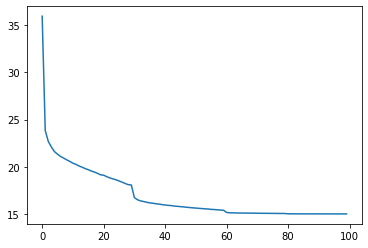

In [10]:
plt.plot(all_train_loss)

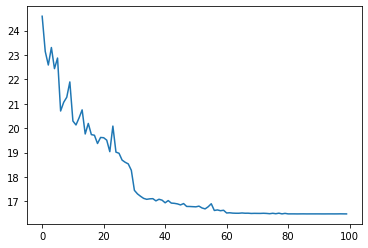

In [11]:
plt.plot(all_val_loss)

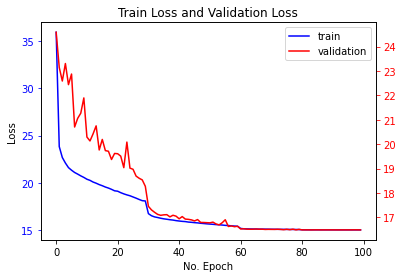

In [12]:
fig, ax = plt.subplots()
ax.plot(all_train_loss, color = 'blue', label = "train")
ax2 = ax.twinx()
ax2.plot(all_val_loss, color = 'red', label = "validation")
ax.tick_params('y', colors='blue')  
ax2.tick_params('y', colors='red')
fig.legend(loc="upper right",bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
ax.set(title='Train Loss and Validation Loss',
      xlabel='No. Epoch', ylabel = 'Loss')
plt.show()